# Clustering Indonesian Cities using Foursquare data to determine ideal locations for new bussiness

In [149]:
##Library/Package import cell.  
##Everything I need to import for this project will go here.

import requests # library to handle requests
from requests import get

import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import geocoder

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

# Scraping Library
from bs4 import BeautifulSoup 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# sklearn libraries for use in Kmeans Elbow Method
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import time # used to sleep the Nominatim function to comply with usage rules

import math # Needed for a radius calculation
    
print('Libraries imported.')

Libraries imported.


## Scraping the Wikipedia Table

[Link to table being used.](https://en.wikipedia.org/wiki/List_of_Indonesian_cities_by_population)

In [150]:
# Load the desired URL for scraping into a variable
url = 'https://en.wikipedia.org/wiki/List_of_Indonesian_cities_by_population' 
# Print a detailed readout of the html at the specified URL
wikiurl = requests.get(url).text
soup = BeautifulSoup(wikiurl,'lxml')
print(soup.prettify()[0:200])

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of Indonesian cities by population - Wikipedia
  </title>
  <script>
   document.docu


In [151]:
# Find the wikitable to be used for the dataframe
# In this instane we are using the 'Built-up Urban Areas' table
table = soup.find('table',{'class':'sortable wikitable plainrowheaders'})

In [152]:
# The names of the Urban Areas are stored in a tags, so this finds all a tags
area_names = table.findAll('a')
area_names

[<a href="#cite_note-Demog16th-6">[6]</a>,
 <a href="/wiki/Jakarta" title="Jakarta">Jakarta</a>,
 <a href="/wiki/Bandung" title="Bandung">Bandung</a>,
 <a href="/wiki/Surabaya" title="Surabaya">Surabaya</a>,
 <a href="/wiki/Medan" title="Medan">Medan</a>,
 <a href="/wiki/Semarang" title="Semarang">Semarang</a>,
 <a href="/wiki/Makassar" title="Makassar">Makassar</a>,
 <a href="/wiki/Palembang" title="Palembang">Palembang</a>,
 <a href="/wiki/Yogyakarta" title="Yogyakarta">Yogyakarta</a>,
 <a href="/wiki/Malang" title="Malang">Malang</a>,
 <a href="/wiki/Denpasar" title="Denpasar">Denpasar</a>,
 <a href="/wiki/Batam" title="Batam">Batam</a>,
 <a href="/wiki/Pekanbaru" title="Pekanbaru">Pekanbaru</a>,
 <a href="/wiki/Surakarta" title="Surakarta">Surakarta</a>,
 <a href="/wiki/Cirebon" title="Cirebon">Cirebon</a>,
 <a href="/wiki/Bandar_Lampung" title="Bandar Lampung">Bandar Lampung</a>,
 <a href="/wiki/Samarinda" title="Samarinda">Samarinda</a>,
 <a href="/wiki/Padang" title="Padang">Pad

In [153]:
# Then this loads all the a tags in order into a list for use in creating a dictionary
namelist = []
for area_name in area_names:
    namelist.append(area_name.get('title'))
del namelist[0] # Drop the first item as it is not a name in the table
namelist

['Jakarta',
 'Bandung',
 'Surabaya',
 'Medan',
 'Semarang',
 'Makassar',
 'Palembang',
 'Yogyakarta',
 'Malang',
 'Denpasar',
 'Batam',
 'Pekanbaru',
 'Surakarta',
 'Cirebon',
 'Bandar Lampung',
 'Samarinda',
 'Padang',
 'Banjarmasin',
 'Tasikmalaya',
 'Pontianak',
 'Balikpapan',
 'Jambi city',
 'Serang',
 'Cilegon']

In [154]:
# Create a list of the table headers for use in creating a dictionary
headers = ['Urban Area', 'Area (Sq. Km)', 'Estimated Population']
headers

['Urban Area', 'Area (Sq. Km)', 'Estimated Population']

In [155]:
# Find all tg tags, which hold all of the data in the table
data = table.findAll('td')

In [156]:
# Loop through the data, assigning the data to a dictionary using the headers list as key values
d = {}
i = 0
n = 0
h = 0
dflist = []

for t in data:
    if i == 0:
        # Skip the first coumn of the table 'rank', as it is not needed
        i = i + 1
        continue
    elif i == 1:
        # Load the 0th index of the headers list 'Urban Area' as key then assign apporpriate index of the namelist
        d[headers[h]] = namelist[n]
        h = h + 1
        n = n + 1
        i = i + 1
        # Load the 1st index of the headers list 'Area (Sq. Km)' as key then assign the current data (the area value)
        d[headers[h]] = t.get_text(strip=True)
        h = h + 1
        continue
    elif i == 2:
        # Load the 2nd index of the headers list 'Population' as key then assign the current data (the population value)
        d[headers[h]] = t.get_text(strip=True)
        # Add dictionary to list, it acts as one row of our dataframe
        dflist.append(d)
        d = {}
        i = 0
        h = 0

In [157]:
# Create the dataframe from the completed list
wikidf = pd.DataFrame(dflist)
wikidf

,Urban Area,Area (Sq. Km),Estimated Population
0,Jakarta,"3,540","34,540,000"
1,Bandung,487,"7,065,000"
2,Surabaya,911,"6,499,000"
3,Medan,478,"3,632,000"
4,Semarang,259,"1,992,000"
5,Makassar,178,"1,952,000"
6,Palembang,221,"1,889,000"
7,Yogyakarta,230,"1,568,000"
8,Malang,212,"1,493,000"
9,Denpasar,177,"1,389,000"


## Adding latitude and longitude columns

In [158]:
# Using Nominatim, loop through the names of the areas and retrieve their lat and long values into lists
lat_lng_coords = None
latitude = []
longitude = []
count = 0
geolocator = Nominatim(user_agent="Indonesia_Scout")

for p in namelist:
    address = p + ', Indonesia'
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    time.sleep(1)
    print(str(latitude[count]) + ', ' + str(longitude[count]))
    count = count + 1

-6.1753942, 106.827183
-6.9344694, 107.6049539
-7.2459717, 112.7378266
3.5896654, 98.6738261
-6.9903988, 110.4229104
-5.1342962, 119.4124282
-2.9888297, 104.756857
-7.8011945, 110.364917
-8.10479815, 112.68798721390587
-8.6524973, 115.2191175
1.1061034, 104.0378246
0.5262455, 101.4515727
-7.5692462, 110.828448
-6.7137044, 108.5608483
-5.4460713, 105.2643742
-0.5017804, 117.1393089
-0.9247587, 100.3632561
-3.3187496, 114.5925828
-7.3262484, 108.2201154
-0.0226903, 109.3447488
-1.2398711, 116.8593379
-1.611572, 102.779699
-6.10565025, 105.98773335759398
-6.017389, 106.0537688


In [159]:
# Create Latitude and Longitude columns in the dataframe and fill them with the values from the lists
wikidf['Latitude'] = latitude
wikidf['Longitude'] = longitude
wikidf

,Urban Area,Area (Sq. Km),Estimated Population,Latitude,Longitude
0,Jakarta,"3,540","34,540,000",-6.175394,106.827183
1,Bandung,487,"7,065,000",-6.934469,107.604954
2,Surabaya,911,"6,499,000",-7.245972,112.737827
3,Medan,478,"3,632,000",3.589665,98.673826
4,Semarang,259,"1,992,000",-6.990399,110.422910
5,Makassar,178,"1,952,000",-5.134296,119.412428
6,Palembang,221,"1,889,000",-2.988830,104.756857
7,Yogyakarta,230,"1,568,000",-7.801195,110.364917
8,Malang,212,"1,493,000",-8.104798,112.687987
9,Denpasar,177,"1,389,000",-8.652497,115.219117


In [160]:
# Replace all ',' with nothing in order to cast the Area column to float for use later
wikidf['Area (Sq. Km)'] = wikidf['Area (Sq. Km)'].str.replace(',', '').astype(float)
wikidf = wikidf.astype({'Area (Sq. Km)': 'float'})
wikidf

,Urban Area,Area (Sq. Km),Estimated Population,Latitude,Longitude
0,Jakarta,3540.0,"34,540,000",-6.175394,106.827183
1,Bandung,487.0,"7,065,000",-6.934469,107.604954
2,Surabaya,911.0,"6,499,000",-7.245972,112.737827
3,Medan,478.0,"3,632,000",3.589665,98.673826
4,Semarang,259.0,"1,992,000",-6.990399,110.422910
5,Makassar,178.0,"1,952,000",-5.134296,119.412428
6,Palembang,221.0,"1,889,000",-2.988830,104.756857
7,Yogyakarta,230.0,"1,568,000",-7.801195,110.364917
8,Malang,212.0,"1,493,000",-8.104798,112.687987
9,Denpasar,177.0,"1,389,000",-8.652497,115.219117


## Initial Map of Area Locations

In [161]:
# Get latitude and longitude values for Indonesia for use in creating the folium map
address = 'Indonesia'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Indonesia are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Indonesia are -2.4833826, 117.8902853.


In [162]:
# create map of Indonesia using latitude and longitude values
map_Indonesia = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, area in zip(wikidf['Latitude'], wikidf['Longitude'], wikidf['Urban Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Indonesia)  
    
map_Indonesia

## Pulling data from Foursquare

In [163]:
# Initialize variables containing Foursqaure api keys

CLIENT_ID = 'GCBFKEZ5L22VF5E1TCFXTRI2PAC1VD3U0XMIQ4XL43AGVZ32'
CLIENT_SECRET = 'TAV1FVLIGCEB3PC0RFTH1MBUUFE0WYO55NYV2WLZV050KMXS'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GCBFKEZ5L22VF5E1TCFXTRI2PAC1VD3U0XMIQ4XL43AGVZ32
CLIENT_SECRET:TAV1FVLIGCEB3PC0RFTH1MBUUFE0WYO55NYV2WLZV050KMXS


In [164]:
# Function to generate a url and request venue information from each Area and store it in a dataframe
def getNearbyVenues(names, latitudes, longitudes, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        i = 0
        radius = math.sqrt(((wikidf.iloc[i, 1])*1000000)/(3.14))
        i = i + 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Urban Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [165]:
# Pass all neighborhoods through the Foursquare function to create the dataframe
Urban_Area_venues = getNearbyVenues(names=wikidf['Urban Area'],
                                   latitudes=wikidf['Latitude'],
                                   longitudes=wikidf['Longitude']
                                  )

Jakarta
Bandung
Surabaya
Medan
Semarang
Makassar
Palembang
Yogyakarta
Malang
Denpasar
Batam
Pekanbaru
Surakarta
Cirebon
Bandar Lampung
Samarinda
Padang
Banjarmasin
Tasikmalaya
Pontianak
Balikpapan
Jambi city
Serang
Cilegon


In [166]:
# Initially had columns misnamed in the forsquare function
#Urban_Area_venues = Urban_Area_venues.rename(columns={'Neighborhood': 'Urban Area',
#                                                      'Neighborhood Latitude': 'Area Latitude',
#                                                      'Neighborhood Longitude': 'Area Longitude'})
Urban_Area_venues.head()

,Urban Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Jakarta,-6.175394,106.827183,Starbucks,-6.166622,106.833779,Coffee Shop
1,Jakarta,-6.175394,106.827183,Starbucks Reserve,-6.194838,106.819669,Coffee Shop
2,Jakarta,-6.175394,106.827183,Rumah Buah,-6.175862,106.802441,Fruit & Vegetable Store
3,Jakarta,-6.175394,106.827183,Grand Hyatt Jakarta,-6.194105,106.822437,Hotel
4,Jakarta,-6.175394,106.827183,Bunga Pepaya,-6.189087,106.835859,Manadonese Restaurant


## Manipulating Foursquare Data

In [167]:
# Obtain number of each kind of venue for each area
vnumbers = pd.DataFrame(columns=['Jakarta'])
for n in wikidf['Urban Area']:
    countdf = Urban_Area_venues[Urban_Area_venues['Urban Area']== n]
    vnumbers[n] = countdf['Venue Category'].value_counts()
vnumbers = vnumbers.T
vnumbers = vnumbers.fillna(0)
vnumbers = vnumbers.astype('int32').reset_index()
vnumbers = vnumbers.rename(columns={'index': 'Urban Area'})
vnumbers.head()

,Urban Area,Hotel,Coffee Shop,Shopping Mall,Indonesian Restaurant,Bakery,Sushi Restaurant,Multiplex,BBQ Joint,Clothing Store,...,Restaurant,Pool,Food Truck,Korean Restaurant,Performing Arts Venue,Pizza Place,Concert Hall,Sandwich Place,Bookstore,Indonesian Meatball Place
0,Jakarta,16,12,6,4,3,3,3,2,2,...,1,1,1,1,1,1,1,1,1,1
1,Bandung,14,18,2,2,15,2,3,0,1,...,1,0,0,1,0,0,0,0,0,0
2,Surabaya,12,14,8,12,5,1,5,1,2,...,2,0,0,1,0,0,0,0,1,1
3,Medan,3,12,1,8,7,3,2,3,2,...,4,0,2,0,0,3,0,0,0,1
4,Semarang,6,6,0,9,0,0,2,2,0,...,0,2,5,2,0,1,0,0,1,0


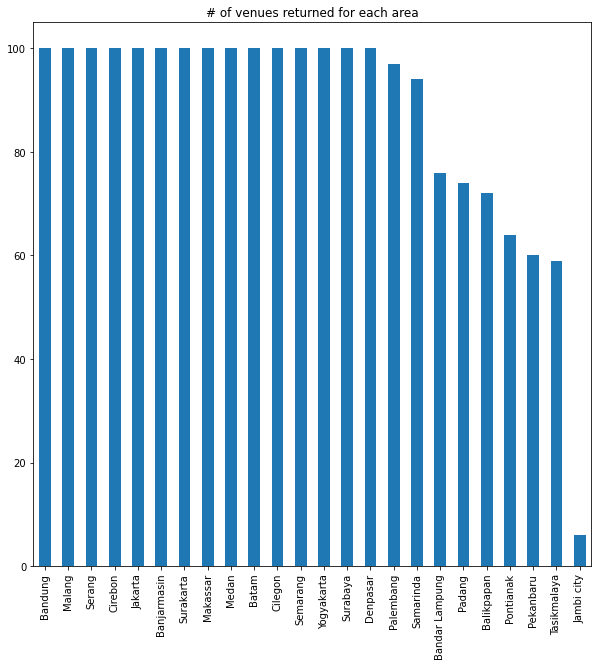

In [189]:
# Plot total number of venues obtained for each area
tvenues = Urban_Area_venues['Urban Area'].value_counts()
tvenues.plot(kind='bar', figsize=(10,10), use_index=True, title='# of venues returned for each area', grid=None, legend=False, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, yerr=None, xerr=None, label=None, secondary_y=False)

In [171]:
# one hot encoding
uav1h = pd.get_dummies(Urban_Area_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uav1h['Urban Area'] = Urban_Area_venues['Urban Area'] 
uav1h = uav1h.groupby('Urban Area').mean().reset_index()
uav1h

,Urban Area,Acehnese Restaurant,Afghan Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Waterfront,Wine Bar,Wings Joint,Yoga Studio
0,Balikpapan,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.013889,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000
1,Bandar Lampung,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000
2,Bandung,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.02,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000
3,Banjarmasin,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.010000,0.000000,...,0.00,0.000000,0.000000,0.00,0.010000,0.00,0.00,0.00,0.00,0.000000
4,Batam,0.00,0.000000,0.010000,0.010000,0.00,0.00,0.000000,0.000000,0.010000,...,0.00,0.000000,0.010000,0.00,0.000000,0.01,0.04,0.01,0.00,0.000000
5,Cilegon,0.00,0.000000,0.000000,0.000000,0.00,0.02,0.000000,0.010000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.01,0.000000
6,Cirebon,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.010000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000
7,Denpasar,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.010000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.010000
8,Jakarta,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.01,0.000000,0.000000,0.01,0.000000,0.00,0.00,0.02,0.00,0.000000
9,Jambi city,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000


In [172]:
# function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [173]:
# Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Urban Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Urban Area'] = uav1h['Urban Area']

for ind in np.arange(uav1h.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(uav1h.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Urban Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balikpapan,Coffee Shop,Seafood Restaurant,Bakery,Indonesian Restaurant,Park,Shopping Mall,Hotel,Café,Lounge,Chinese Restaurant
1,Bandar Lampung,Indonesian Restaurant,Beach,Coffee Shop,Noodle House,Hotel,Chinese Restaurant,Bakery,Snack Place,Fast Food Restaurant,Breakfast Spot
2,Bandung,Coffee Shop,Bakery,Hotel,Café,Japanese Restaurant,Sundanese Restaurant,Multiplex,Steakhouse,Shopping Mall,Udon Restaurant
3,Banjarmasin,Hotel,Indonesian Restaurant,Café,Diner,Coffee Shop,Breakfast Spot,Soup Place,Asian Restaurant,Food,Fast Food Restaurant
4,Batam,Hotel,Coffee Shop,Beach,Waterfront,Ice Cream Shop,Theme Park Ride / Attraction,Resort,Café,Shopping Mall,Botanical Garden
5,Cilegon,Indonesian Restaurant,Asian Restaurant,Café,Hotel,Beach,Resort,Diner,Soup Place,Fast Food Restaurant,Food Truck
6,Cirebon,Indonesian Restaurant,Hotel,Café,Asian Restaurant,Coffee Shop,Bakery,Gift Shop,Restaurant,Supermarket,Sundanese Restaurant
7,Denpasar,Café,Hotel,Restaurant,Resort,Coffee Shop,Indonesian Restaurant,Beach,Bakery,Chinese Restaurant,Surf Spot
8,Jakarta,Hotel,Coffee Shop,Shopping Mall,Indonesian Restaurant,Multiplex,Sushi Restaurant,Bakery,Nightclub,Clothing Store,Chinese Restaurant
9,Jambi city,Convenience Store,River,Scenic Lookout,Trail,Pizza Place,Hotel,Farm,Food Court,Food & Drink Shop,Food


## Clustering the data

In [174]:
# Calculating ideal k value using the Elbow Method

# Grouped Urban Areas with Venues dataframe for clustering
uavk = uav1h.drop('Urban Area', 1)

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,25) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(uavk) 
    kmeanModel.fit(uavk)     
      
    distortions.append(sum(np.min(cdist(uavk, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / uavk.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(uavk, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / uavk.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


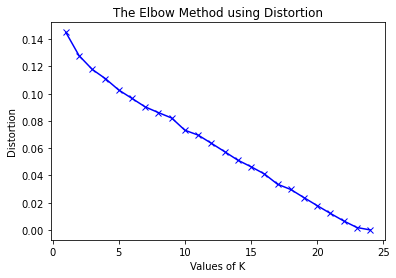

In [175]:

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


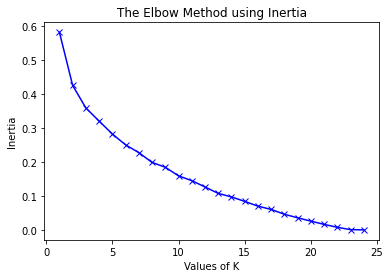

In [176]:

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


In [177]:
# set number of clusters
k = 3

# Grouped Urban Areas with Venues dataframe for clustering
uavk = uav1h.drop('Urban Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=3).fit(uavk)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 1, 2, 1, 1, 1, 2, 0])

In [178]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# create a data frame for merging (wikidf + venues)
dfv = wikidf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dfv = dfv.join(neighborhoods_venues_sorted.set_index('Urban Area'), on='Urban Area')

dfv.head() # check the last columns!

,Urban Area,Area (Sq. Km),Estimated Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jakarta,3540.0,"34,540,000",-6.175394,106.827183,2,Hotel,Coffee Shop,Shopping Mall,Indonesian Restaurant,Multiplex,Sushi Restaurant,Bakery,Nightclub,Clothing Store,Chinese Restaurant
1,Bandung,487.0,"7,065,000",-6.934469,107.604954,2,Coffee Shop,Bakery,Hotel,Café,Japanese Restaurant,Sundanese Restaurant,Multiplex,Steakhouse,Shopping Mall,Udon Restaurant
2,Surabaya,911.0,"6,499,000",-7.245972,112.737827,2,Coffee Shop,Hotel,Indonesian Restaurant,Shopping Mall,Multiplex,Bakery,Steakhouse,Supermarket,Movie Theater,Seafood Restaurant
3,Medan,478.0,"3,632,000",3.589665,98.673826,1,Coffee Shop,Indonesian Restaurant,Bakery,Chinese Restaurant,Restaurant,Seafood Restaurant,Noodle House,Spa,Pizza Place,BBQ Joint
4,Semarang,259.0,"1,992,000",-6.990399,110.422910,1,Indonesian Restaurant,Asian Restaurant,Coffee Shop,Hotel,Food Truck,Chinese Restaurant,Snack Place,Steakhouse,Seafood Restaurant,Food Court


In [179]:
# create a data frame for merging
dfvnumbers = wikidf

# merge to get numbers of each venue on main dataframe
dfvnumbers = dfv.join(vnumbers.set_index('Urban Area'), on='Urban Area')

#drop everything except cluster label and number of each venue
dfvnclusters = dfvnumbers.drop(columns=['Urban Area', 'Area (Sq. Km)', 'Estimated Population',
                                        'Latitude', 'Longitude','1st Most Common Venue',
                                        '2nd Most Common Venue', '3rd Most Common Venue',
                                       '4th Most Common Venue', '5th Most Common Venue',
                                       '6th Most Common Venue', '7th Most Common Venue',
                                       '8th Most Common Venue', '9th Most Common Venue',
                                       '10th Most Common Venue'])

In [180]:
# use the previous dataframe to get totals of each kind of venue for the whole cluster and store in new dataframe
d = {}
l = []
clustern = pd.DataFrame(index=range(0,3),columns=dfvnclusters.columns)
for c in range(0,3):
    summer = dfvnclusters.loc[dfvnclusters['Cluster Labels'] == c]
    for h in summer.columns:
        clustern.loc[c,h] = summer[h].sum()
    
clustern = clustern.drop(columns = ['Cluster Labels'])
clustern

,Hotel,Coffee Shop,Shopping Mall,Indonesian Restaurant,Bakery,Sushi Restaurant,Multiplex,BBQ Joint,Clothing Store,Steakhouse,...,Restaurant,Pool,Food Truck,Korean Restaurant,Performing Arts Venue,Pizza Place,Concert Hall,Sandwich Place,Bookstore,Indonesian Meatball Place
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,116,96,22,159,38,9,20,10,7,14,...,32,8,27,6,2,20,0,0,5,15
2,70,54,19,27,28,8,12,5,5,11,...,6,2,3,3,4,4,2,1,3,2


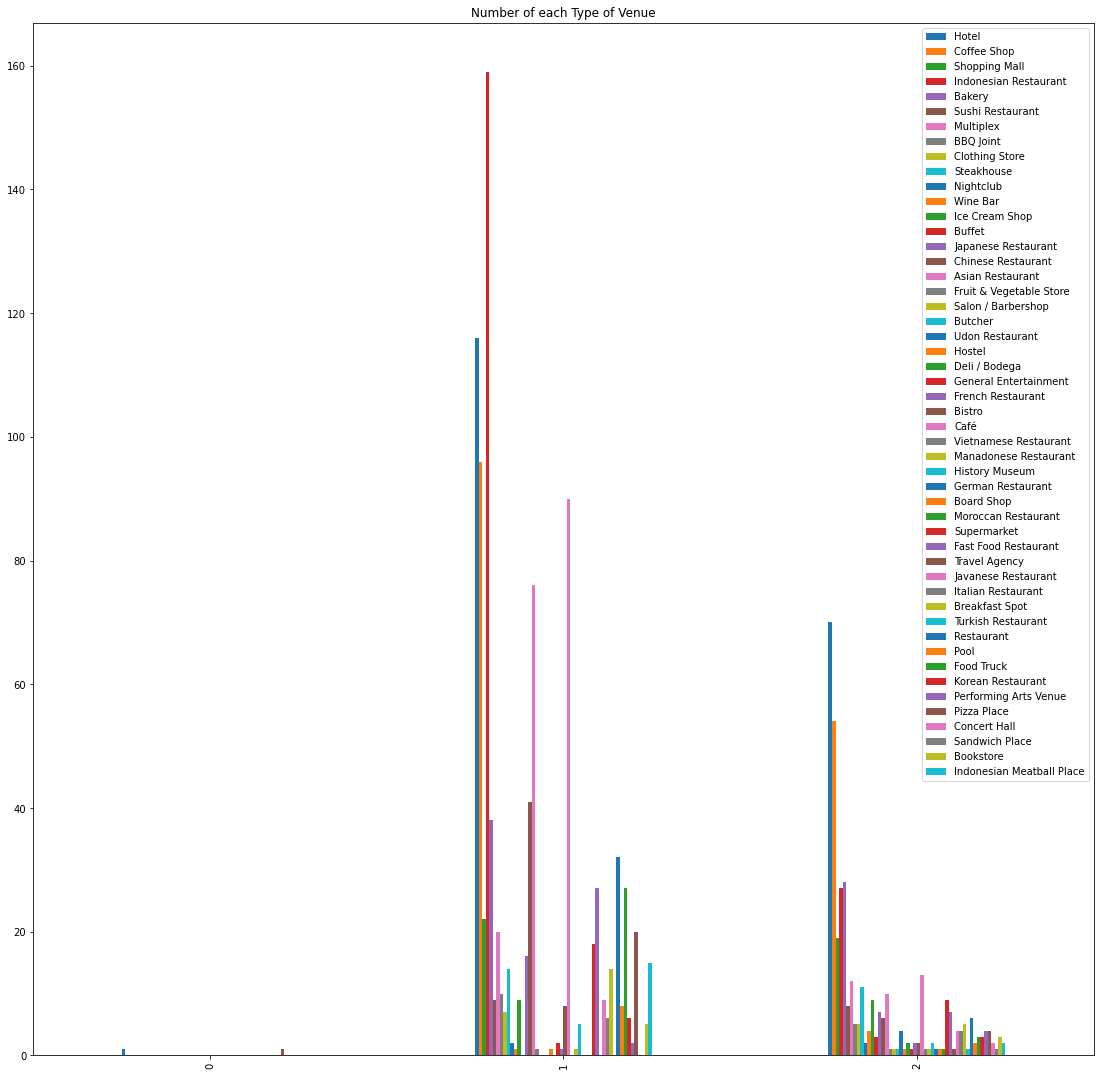

In [188]:
# plot the dataframe
clustern.plot(kind='bar', figsize=(19, 19), use_index=True, title='Number of each Type of Venue', grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, yerr=None, xerr=None, label=None, secondary_y=False)

In [182]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfv['Latitude'], dfv['Longitude'], dfv['Urban Area'], dfv['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Slicing the dataframe into clusters

In [183]:
dfv.loc[dfv['Cluster Labels'] == 0, dfv.columns[[0,1] + list(range(5, dfv.shape[1]))]]

,Urban Area,Area (Sq. Km),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Jambi city,78.0,0,Convenience Store,River,Scenic Lookout,Trail,Pizza Place,Hotel,Farm,Food Court,Food & Drink Shop,Food


In [184]:
dfv.loc[dfv['Cluster Labels'] == 1, dfv.columns[[0,1] + list(range(5, dfv.shape[1]))]]

,Urban Area,Area (Sq. Km),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Medan,478.0,1,Coffee Shop,Indonesian Restaurant,Bakery,Chinese Restaurant,Restaurant,Seafood Restaurant,Noodle House,Spa,Pizza Place,BBQ Joint
4,Semarang,259.0,1,Indonesian Restaurant,Asian Restaurant,Coffee Shop,Hotel,Food Truck,Chinese Restaurant,Snack Place,Steakhouse,Seafood Restaurant,Food Court
5,Makassar,178.0,1,Hotel,Coffee Shop,Indonesian Restaurant,Café,Seafood Restaurant,Soup Place,Noodle House,Snack Place,Pizza Place,Clothing Store
6,Palembang,221.0,1,Indonesian Restaurant,Noodle House,Asian Restaurant,Café,Multiplex,Coffee Shop,Restaurant,Donut Shop,Shopping Mall,Hotel
8,Malang,212.0,1,Hotel,Soup Place,Coffee Shop,Café,Indonesian Restaurant,Supermarket,Chinese Restaurant,Indonesian Meatball Place,Snack Place,Asian Restaurant
9,Denpasar,177.0,1,Café,Hotel,Restaurant,Resort,Coffee Shop,Indonesian Restaurant,Beach,Bakery,Chinese Restaurant,Surf Spot
11,Pekanbaru,239.0,1,Café,Indonesian Restaurant,Asian Restaurant,Coffee Shop,Hotel,Seafood Restaurant,Chinese Restaurant,Diner,Dessert Shop,Fried Chicken Joint
12,Surakarta,477.0,1,Indonesian Restaurant,Hotel,Coffee Shop,Asian Restaurant,Snack Place,Shopping Mall,Pizza Place,Café,Fried Chicken Joint,Soup Place
13,Cirebon,105.0,1,Indonesian Restaurant,Hotel,Café,Asian Restaurant,Coffee Shop,Bakery,Gift Shop,Restaurant,Supermarket,Sundanese Restaurant
14,Bandar Lampung,107.0,1,Indonesian Restaurant,Beach,Coffee Shop,Noodle House,Hotel,Chinese Restaurant,Bakery,Snack Place,Fast Food Restaurant,Breakfast Spot


In [185]:
dfv.loc[dfv['Cluster Labels'] == 2, dfv.columns[[0,1] + list(range(5, dfv.shape[1]))]]

,Urban Area,Area (Sq. Km),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jakarta,3540.0,2,Hotel,Coffee Shop,Shopping Mall,Indonesian Restaurant,Multiplex,Sushi Restaurant,Bakery,Nightclub,Clothing Store,Chinese Restaurant
1,Bandung,487.0,2,Coffee Shop,Bakery,Hotel,Café,Japanese Restaurant,Sundanese Restaurant,Multiplex,Steakhouse,Shopping Mall,Udon Restaurant
2,Surabaya,911.0,2,Coffee Shop,Hotel,Indonesian Restaurant,Shopping Mall,Multiplex,Bakery,Steakhouse,Supermarket,Movie Theater,Seafood Restaurant
7,Yogyakarta,230.0,2,Hotel,Indonesian Restaurant,Coffee Shop,Asian Restaurant,Bakery,Pizza Place,Breakfast Spot,Javanese Restaurant,Food Truck,Fast Food Restaurant
10,Batam,243.0,2,Hotel,Coffee Shop,Beach,Waterfront,Ice Cream Shop,Theme Park Ride / Attraction,Resort,Café,Shopping Mall,Botanical Garden
